In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-02-23 16:30:28.968383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns=["DepMap_ID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(751, 1000)


,GPX4 (2879),CDK6 (1021),CCND1 (595),ITGAV (3685),FBXW11 (23291),FERMT2 (10979),PCYT1A (5130),SCAP (22937),TYMS (7298),CFLAR (8837),...,TRAIP (10293),SPTLC2 (9517),SIVA1 (10572),ARF6 (382),MTX2 (10651),SUDS3 (64426),RFWD3 (55159),PEF1 (553115),VDAC2 (7417),EIF3L (51386)
0,0.463823,0.014317,0.161896,0.085363,0.298268,0.051738,0.932488,0.876329,0.426153,0.360063,...,0.592945,0.040897,0.028690,0.255672,0.049467,0.686069,0.095030,0.379675,0.147619,0.312850
1,0.972063,0.064748,0.022768,0.977996,0.976181,0.875408,0.895123,0.094826,0.058741,0.812678,...,0.854894,0.143725,0.021591,0.383889,0.142221,0.655798,0.159654,0.438015,0.443068,0.244777
2,0.983013,0.987171,0.014462,0.011497,0.945816,0.122422,0.989659,0.990821,0.308549,0.088603,...,0.897589,0.684485,0.361767,0.869974,0.262962,0.402732,0.953677,0.385210,0.237527,0.841037


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(133, 1000)


,GPX4 (2879),CDK6 (1021),CCND1 (595),ITGAV (3685),FBXW11 (23291),FERMT2 (10979),PCYT1A (5130),SCAP (22937),TYMS (7298),CFLAR (8837),...,TRAIP (10293),SPTLC2 (9517),SIVA1 (10572),ARF6 (382),MTX2 (10651),SUDS3 (64426),RFWD3 (55159),PEF1 (553115),VDAC2 (7417),EIF3L (51386)
0,0.843742,0.283810,0.941577,0.996565,0.992670,0.971852,0.331270,0.039042,0.586814,0.182726,...,0.962914,0.122600,0.055387,0.193870,0.160739,0.621019,0.459644,0.685886,0.329888,0.212550
1,0.968403,0.031842,0.026362,0.999368,0.086760,0.976968,0.870871,0.554008,0.413046,0.230640,...,0.781397,0.900710,0.010781,0.910202,0.086714,0.670193,0.278292,0.713822,0.265914,0.167114
2,0.845370,0.403622,0.507205,0.660745,0.672061,0.895860,0.547123,0.685342,0.086716,0.666695,...,0.942949,0.136824,0.714577,0.278318,0.116243,0.737946,0.685493,0.696300,0.068160,0.288178


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=100,
    batch_size=112,
    encoder_batch_norm=True,
    epochs=905,
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=10,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-02-23 16:30:46.653462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/905
7/7 [==============================] - 1s 41ms/step - loss: 967.2993 - recon: 499.6991 - kl: 467.6002 - val_loss: 15291.9141 - val_recon: 4261.9785 - val_kl: 11029.9375
Epoch 2/905
7/7 [==============================] - 0s 10ms/step - loss: 579.5389 - recon: 235.5556 - kl: 343.9832 - val_loss: 44201.4297 - val_recon: 11414.1621 - val_kl: 32787.2656
Epoch 3/905
7/7 [==============================] - 0s 10ms/step - loss: 449.7882 - recon: 173.5634 - kl: 276.2249 - val_loss: 25736.3789 - val_recon: 5516.5537 - val_kl: 20219.8242
Epoch 4/905
7/7 [==============================] - 0s 11ms/step - loss: 364.9896 - recon: 133.2309 - kl: 231.7587 - val_loss: 10828.8076 - val_recon: 2518.2959 - val_kl: 8310.5127
Epoch 5/905
7/7 [==============================] - 0s 10ms/step - loss: 330.9792 - recon: 129.4317 - kl: 201.5475 - val_loss: 6182.4712 - val_recon: 2152.6299 - val_kl: 4029.8416
Epoch 6/905
7/7 [==============================] - 0s 10ms/step - loss: 300.9589 - recon: 120.736

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......add_loss
.........vars
......add_metric
........._metrics
............mean
...............vars
..................0
..................1
.........vars
......add_metric_1
........._metrics
............mean
...............vars
..................0
..................1
.........vars
......functional
.........layers
............activation
...............vars
............activation_1
...............vars
............batch_normalization
...............vars
..................0
..................1
..................2
..................3
............batch_normalization_1
...............vars
..................0
..................1
..................2
..................3
............dense
...............vars
..................0
..................1
............dense_1
...............vars
..................0
..................1
............lambda
...............vars
.........vars
......functional_1
.........layers
........

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

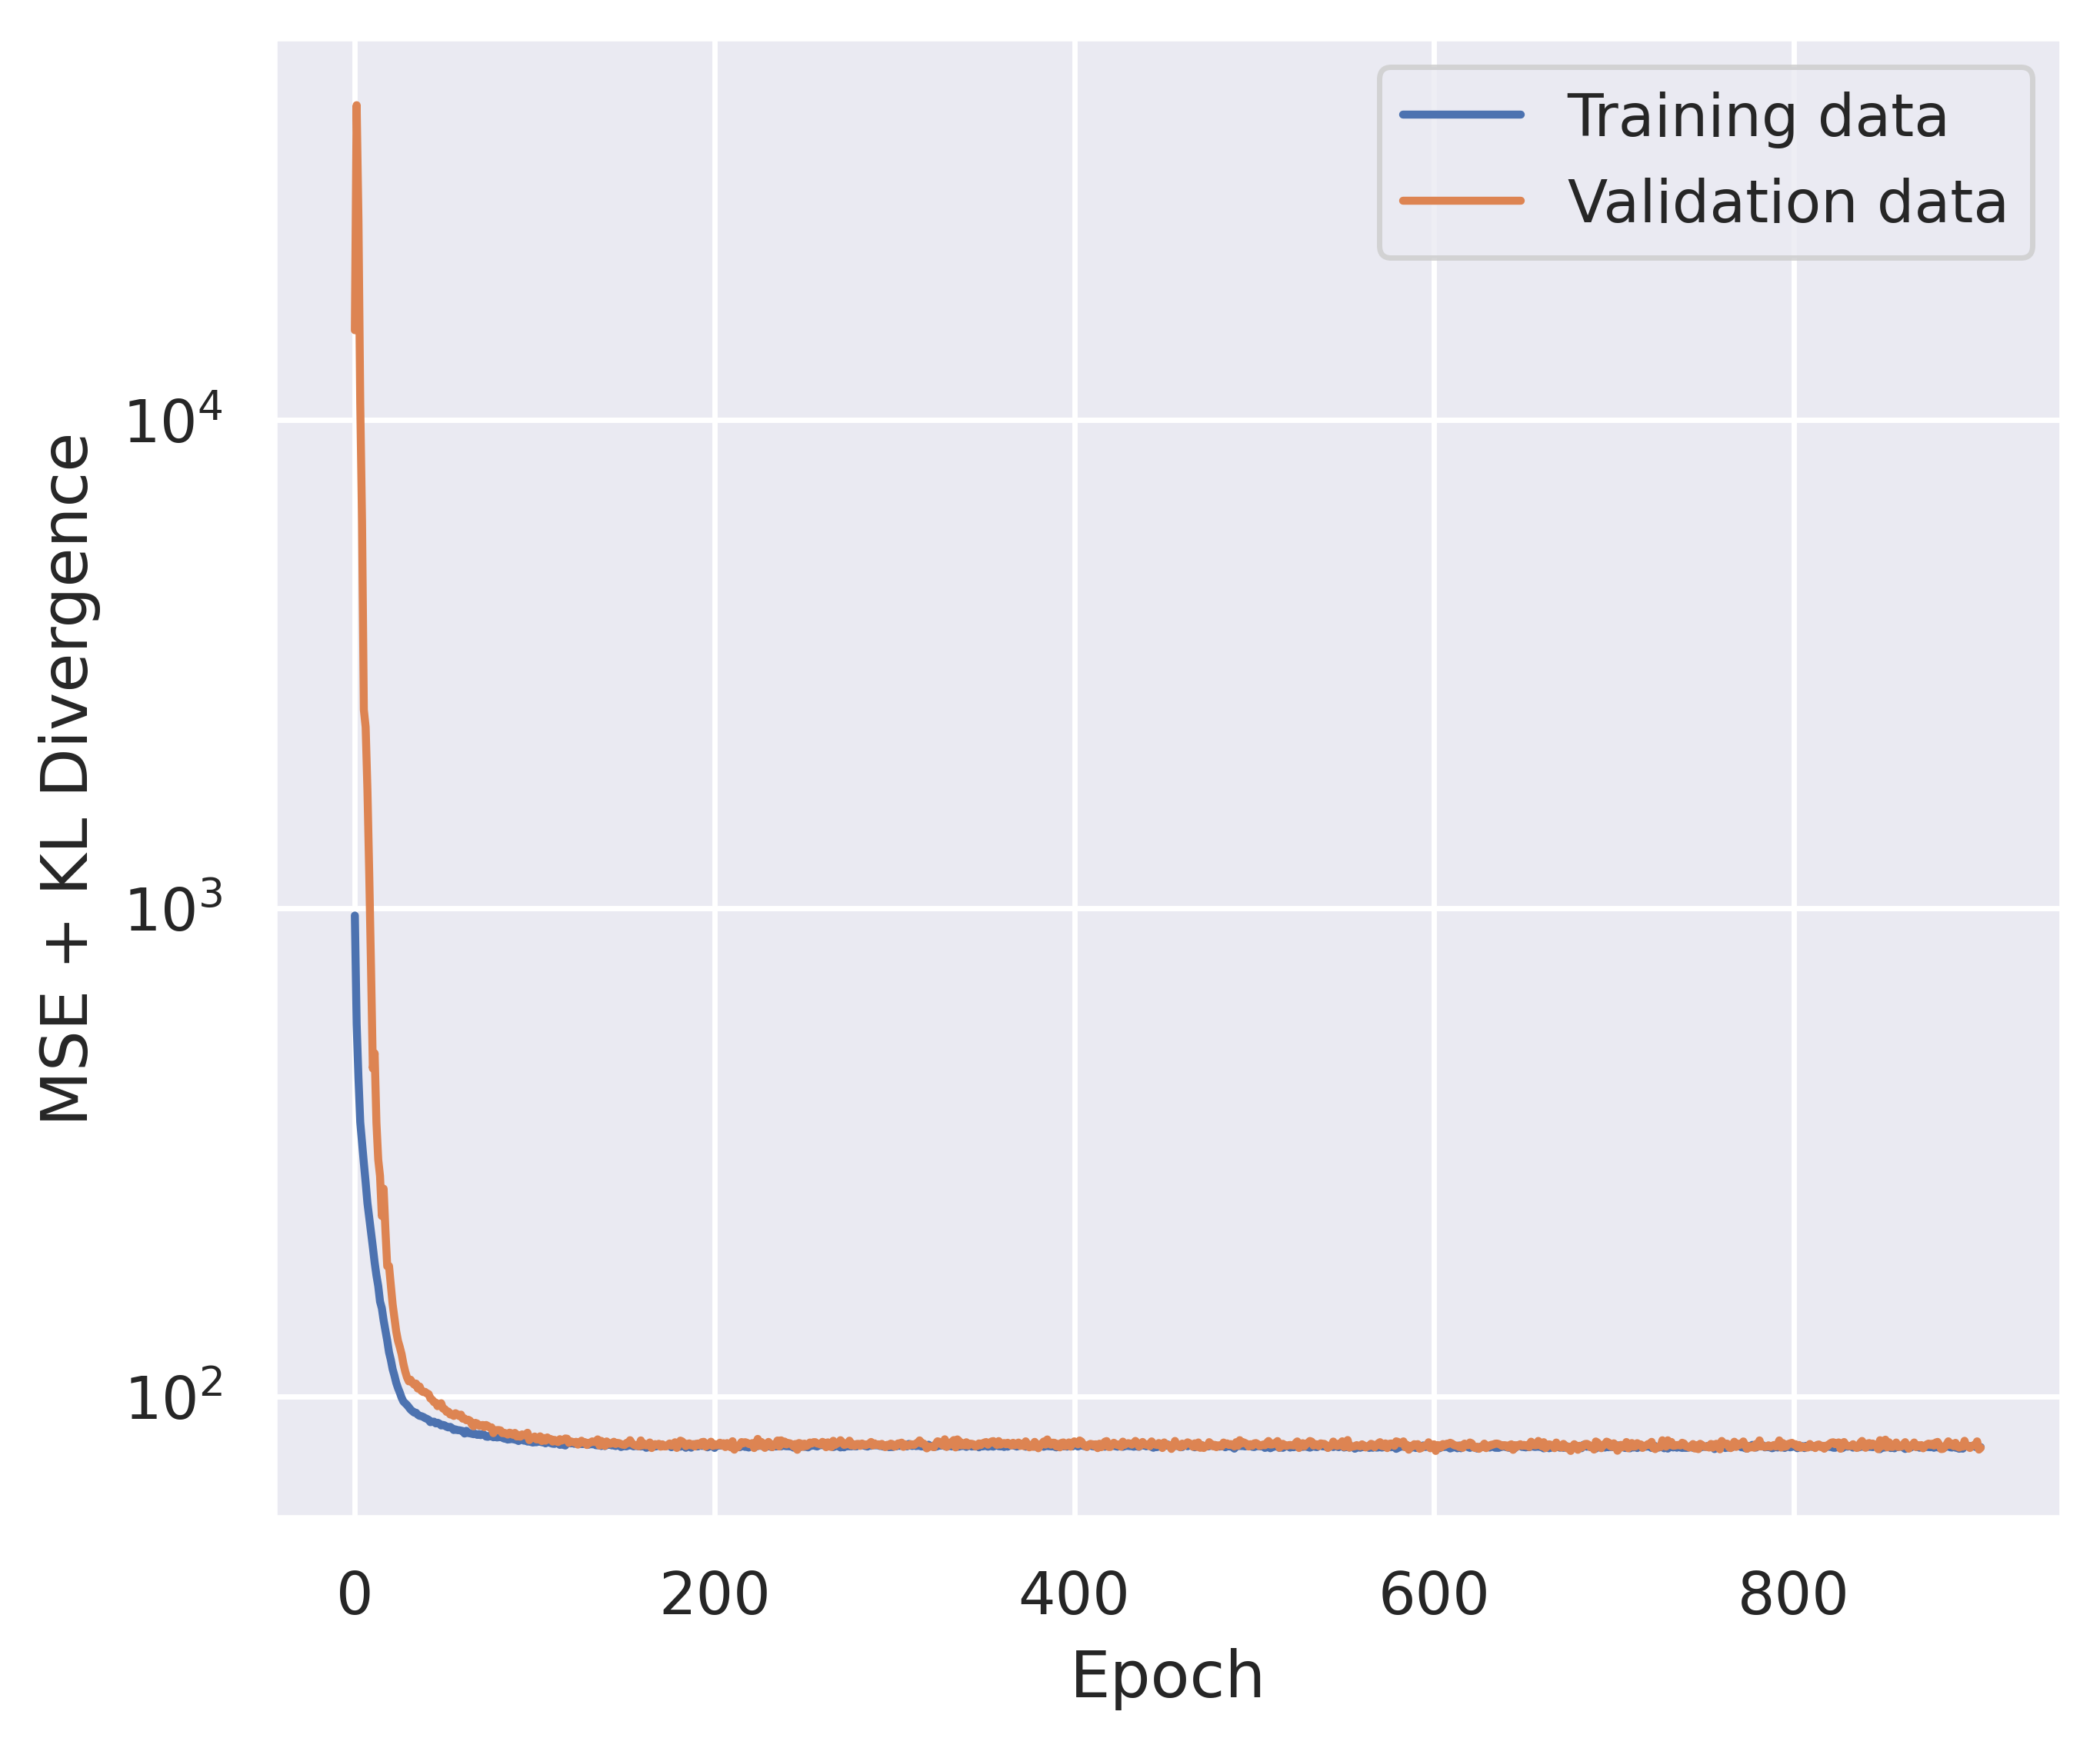

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
#Need to add code here to close those model

In [15]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [16]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [17]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [18]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    DepMap_ID=train_and_test.DepMap_ID.astype(str),
    age_category=train_and_test.age_category.astype(str),
    sex=train_and_test.sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-000438,Adult,Male,train
1,ACH-000903,Adult,Male,train
2,ACH-000271,Adult,Male,train
3,ACH-000055,Pediatric,Male,train
4,ACH-000757,Adult,Male,train
...,...,...,...,...
879,ACH-000984,Adult,Female,test
880,ACH-000420,Adult,Male,test
881,ACH-000490,Adult,Female,test
882,ACH-000957,Adult,Female,test


In [19]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the DepMap IDs added back in
extracted_col = metadata['DepMap_ID']

latent_df.insert(0, 'DepMap_ID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

28/28 [==============================] - 0s 1ms/step


,DepMap_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ACH-000438,-0.366216,0.366764,0.023161,0.820144,-1.270948,-0.086733,-1.396885,0.196348,0.503913,...,0.354352,1.520405,0.116153,-1.497384,-0.045450,-1.351954,-0.433699,1.738801,0.454020,1.003657
1,ACH-000903,-1.373164,-0.565102,-0.494976,1.722680,-0.255840,-0.258159,-0.679059,-0.027773,-0.759461,...,0.479026,0.583630,1.194526,-0.639946,0.080747,-1.672692,1.429650,-2.839149,0.994645,1.066638
2,ACH-000271,0.525342,0.226953,0.426089,1.155439,0.329113,1.122038,0.388267,-0.120655,1.061722,...,0.540154,-1.117755,-0.006844,0.111050,-0.248132,2.390469,0.200227,0.185597,2.456012,-0.421881
3,ACH-000055,-0.635151,-2.042248,0.717198,0.262979,-0.410099,0.549809,2.151354,-0.886611,0.100390,...,1.121050,0.683430,0.053671,0.991721,-0.214476,-0.864326,0.512332,0.163883,1.430979,-1.738265
4,ACH-000757,1.017952,-0.556430,0.461341,-0.536619,-0.146383,-0.533102,0.740360,0.646794,0.748446,...,-0.356151,1.676313,0.624631,1.682499,2.343215,1.865505,0.384006,2.362561,1.060612,2.189859


In [20]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.027460,-0.070779,0.001731,-0.094848,0.073441,-0.045740,-0.013464,-0.003496,-0.054087,0.114389,...,-0.001064,-0.025719,-0.051441,-0.059867,-0.047008,-0.097932,0.047892,-0.098538,-0.076435,-0.097514
1,0.002897,-0.163369,-0.048610,0.013512,0.006774,-0.013377,-0.061763,0.044270,-0.067225,-0.024671,...,-0.032070,-0.011596,0.032896,0.024067,-0.014068,-0.109819,-0.040015,-0.151256,-0.070344,-0.050638
2,0.068403,0.170713,-0.107413,-0.019957,-0.091245,-0.027354,-0.013429,-0.002953,0.020394,-0.045961,...,-0.156945,0.088128,-0.012880,-0.036969,0.005773,0.013009,-0.094061,0.222050,0.079966,0.150750
3,0.104246,0.044185,-0.065313,-0.095490,0.022715,-0.062570,0.006958,0.025696,0.023273,0.030976,...,-0.031745,0.041369,-0.015924,-0.087925,-0.021463,0.022722,-0.096038,0.010021,0.092492,0.092633
4,-0.061374,-0.073591,-0.018279,-0.016236,0.008553,-0.037758,0.008728,0.002456,-0.036165,-0.012164,...,0.097396,0.059990,0.030646,-0.013488,-0.032021,0.040819,-0.021807,-0.048628,-0.061967,-0.038415


In [21]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,GPX4,-0.027460,-0.070779,0.001731,-0.094848,0.073441,-0.045740,-0.013464,-0.003496,-0.054087,...,-0.001064,-0.025719,-0.051441,-0.059867,-0.047008,-0.097932,0.047892,-0.098538,-0.076435,-0.097514
1,CDK6,0.002897,-0.163369,-0.048610,0.013512,0.006774,-0.013377,-0.061763,0.044270,-0.067225,...,-0.032070,-0.011596,0.032896,0.024067,-0.014068,-0.109819,-0.040015,-0.151256,-0.070344,-0.050638
2,CCND1,0.068403,0.170713,-0.107413,-0.019957,-0.091245,-0.027354,-0.013429,-0.002953,0.020394,...,-0.156945,0.088128,-0.012880,-0.036969,0.005773,0.013009,-0.094061,0.222050,0.079966,0.150750
3,ITGAV,0.104246,0.044185,-0.065313,-0.095490,0.022715,-0.062570,0.006958,0.025696,0.023273,...,-0.031745,0.041369,-0.015924,-0.087925,-0.021463,0.022722,-0.096038,0.010021,0.092492,0.092633
4,FBXW11,-0.061374,-0.073591,-0.018279,-0.016236,0.008553,-0.037758,0.008728,0.002456,-0.036165,...,0.097396,0.059990,0.030646,-0.013488,-0.032021,0.040819,-0.021807,-0.048628,-0.061967,-0.038415
